![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

# Project: Analyzing Bitcoin crash

For this project, we will be reviewing the reasons for the most recent bitcoin crash.

We will be doing Visualizations, identifying trends and provide data-driven recommendations or information, so that every stakeholder, and myself of course, can take action.

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

Let's start by describing how the analysis will be taken. We will be using Python libraries (pandas, numpy and matplotlib) for the process. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
#let's import the dataset from the web and clean it
btc = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1624646714&period2=1656182714&interval=1d&events=history&includeAdjustedClose=true") 
btc['Date'] = pd.to_datetime(btc['Date']) # parse Date from object to datetime64

btc.dropna() #drop null values, used btc.isnull().sum()
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-06-25,34659.105469,35487.246094,31350.884766,31637.779297,31637.779297,40230904226
1,2021-06-26,31594.664063,32637.587891,30184.501953,32186.277344,32186.277344,38585385521
2,2021-06-27,32287.523438,34656.128906,32071.757813,34649.644531,34649.644531,35511640894
3,2021-06-28,34679.121094,35219.890625,33902.074219,34434.335938,34434.335938,33892523752
4,2021-06-29,34475.558594,36542.109375,34252.484375,35867.777344,35867.777344,37901460044


Seems good to me, but for visualizing stocks, tipically we use the Daily Mean. Let's add it to the dataframe.

In [3]:
btc['Mean'] = (btc['Open'] + btc['Close']) / 2
btc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Mean
0,2021-06-25,34659.105469,35487.246094,31350.884766,31637.779297,31637.779297,40230904226,33148.442383
1,2021-06-26,31594.664063,32637.587891,30184.501953,32186.277344,32186.277344,38585385521,31890.470703
2,2021-06-27,32287.523438,34656.128906,32071.757813,34649.644531,34649.644531,35511640894,33468.583985
3,2021-06-28,34679.121094,35219.890625,33902.074219,34434.335938,34434.335938,33892523752,34556.728516
4,2021-06-29,34475.558594,36542.109375,34252.484375,35867.777344,35867.777344,37901460044,35171.667969


Now that we have a clean dataframe, let's begin analyzing it. First, let's quickly plot it so that we have a visual to base on.

Text(358   2022-06-18
Name: Date, dtype: datetime64[ns], 18108.623047, '$17708')

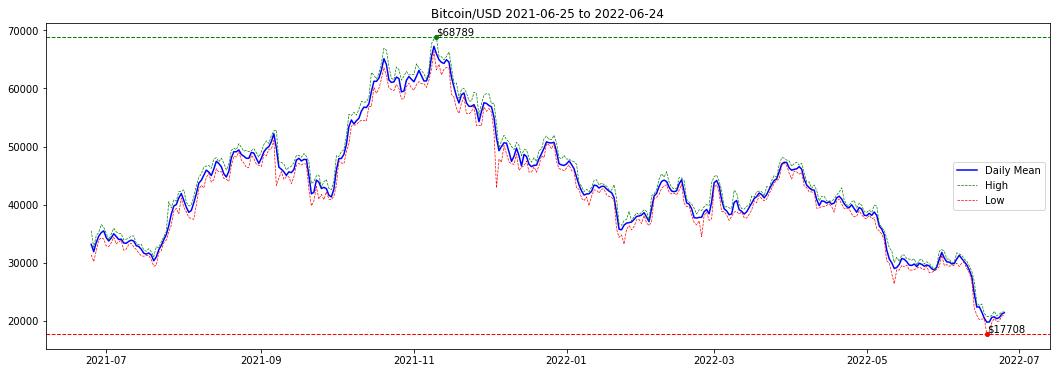

In [4]:
plt.figure(figsize=(18,6))
plt.title('Bitcoin/USD 2021-06-25 to 2022-06-24')
plt.plot(btc['Date'], btc['Mean'], color="blue", linewidth = 1.5)
plt.plot(btc['Date'], btc['High'], color = "green", linewidth=.7, linestyle='dashed')
plt.plot(btc['Date'], btc['Low'], color ="red", linewidth=.7, linestyle='dashed')
plt.legend(['Daily Mean', 'High', 'Low'])
plt.plot(btc.loc[btc['High'].max() == btc['High'], 'Date'], btc['High'].max(), marker="o", color = "green", markersize=4)
plt.plot(btc.loc[btc['Low'].min() == btc['Low'], 'Date'], btc['Low'].min(), marker="o", color = "red", markersize=4)
plt.axhline(y=btc['High'].max(), color='g', linestyle='dashed', linewidth=1, label="Maximo historico")
plt.axhline(y=btc['Low'].min(), color='r', linestyle='dashed', linewidth=1)
plt.annotate('${}'.format(int(btc['High'].max())), xy=(btc.loc[btc['High'].max() == btc['High'], 'Date'], btc['High'].max() + 400))
plt.annotate('${}'.format(int(btc['Low'].min())) , xy=(btc.loc[btc['Low'].min() == btc['Low'], 'Date'], btc['Low'].min() + 400))

As we can see on the graph, this stock is from 2021-06 to 2022-06. For a more detailed and complex analysis, we could use the historical, but we won't be needing it because our goal is to analyze the most recent bitcoin crash.

Even though there is an obvious drop in the price from 2021-11 to 2022-06, there are several market rebounds and trend reversals, that affect our analysis. 

As a simple explanation, a market rebound is when the price increase or decrease, and the price is not representative so it is corrected slightly by the market. 

A trend reversal is when a trend changed from decreasing to increasing (or viceversa). We can define a trend as a prediction of how the price will fluctuate in the future. If it is an increasing trend or bull market, the mins and maxs are higher everytime between rebounds. If it is a decreasing trend or bear market, the mins and maxs are lower.

Let's look for relevant maximums and minimums, we will be using the Daily Mean value of bitcoin.

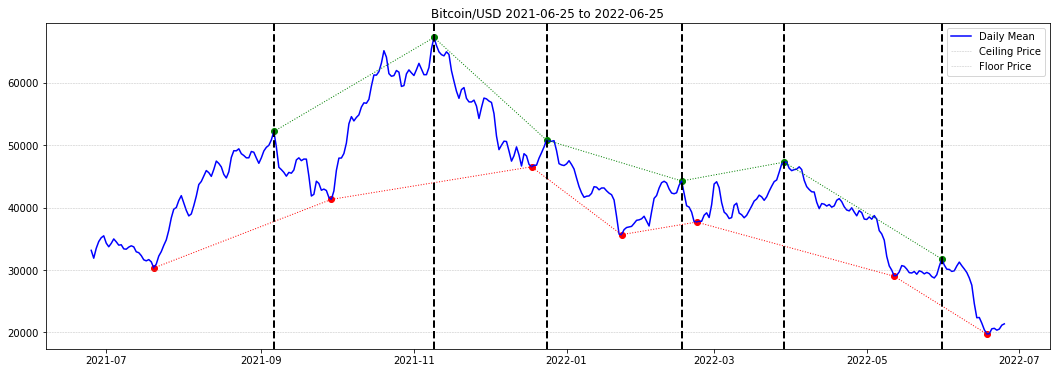

In [132]:
plt.figure(figsize=(18,6))
plt.title('Bitcoin/USD 2021-06-25 to 2022-06-25')
plt.plot(btc['Date'], btc['Mean'], color="blue", linewidth = 1.5)
#Draw visual reference for prices
[plt.axhline(y=i, color='gray', linewidth = .5, linestyle  = 'dashed', alpha=.5)  for i in [20000, 30000, 40000, 50000, 60000]]
maximums = []
minimums = []
#Verify if value is local maximum or minimum and if it is preceeding a fall.
for x in range(0, btc['Mean'].shape[0]):
    if((btc['Mean'][x] - btc['Mean'][x-15:x].mean() > 0) & (btc['Mean'][x] == btc['Mean'][x-15:x+15].max()) & ((btc['Mean'][x] - btc['Mean'][x:x+25].mean() > 3000))): 
        maximums.append(x)
    if((btc['Mean'][x] - btc['Mean'][x-15:x].mean() < -1000) & (btc['Mean'][x] == btc['Mean'][x-15:x+15].min())):
        minimums.append(x)

df= pd.Series(maximums, dtype=float)
maxs = btc.loc[btc.index.isin(df)]
plt.plot(maxs['Date'], maxs['Mean'], color = "green", linestyle='dotted', linewidth=1)
plt.scatter(maxs['Date'], maxs['Mean'], color = "green")
df= minimums
mins = btc.loc[btc.index.isin(df)]
plt.plot(mins['Date'], mins['Mean'], color = "red", linestyle='dotted', linewidth=1)
plt.scatter(mins['Date'], mins['Mean'], color = "red")
plt.legend(['Daily Mean', 'Ceiling Price', 'Floor Price'])

[plt.axvline(x=i, color='black', linewidth = 2, linestyle  ='--',)  for i in maxs['Date']]

We now can clearly review the consecutive drops on the ceiling price and the floor price, that means we are in a overall bear market since 2021-11, with a market rebound during the period 2022/02 - 2022/04. Therefore, let's zoom into the bear market, and identify the drops so we can analyze the last crash and make data-driven recommendations.

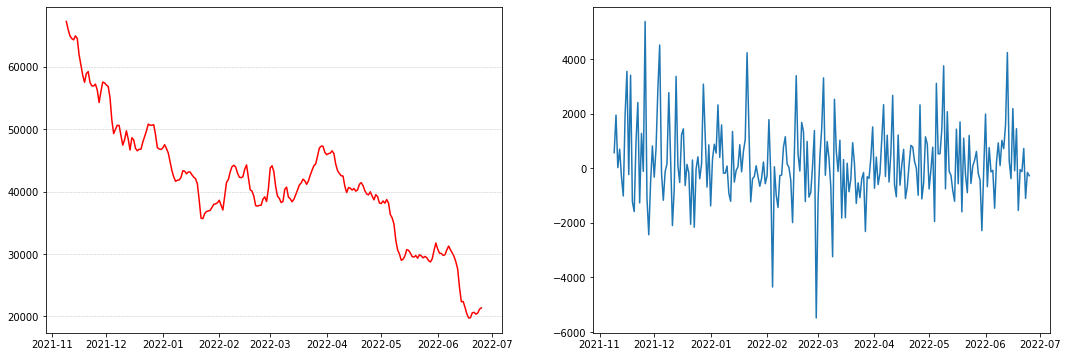

In [150]:
plt.figure(figsize=(18,6))
plt.title('Bitcoin/USD 2021-11-09 to 2022-06-25')
plt.subplot(1, 2, 1) 
#btc[(btc.loc[btc['Mean'] == btc['Mean'].max(), 'Date']):(btc['Date'].last_valid_index)]
zoom = btc[btc[btc['Mean'] == btc['Mean'].max()].index[0]:]
plt.plot(zoom['Date'], zoom['Mean'], color="red", linewidth=1.5)
[plt.axhline(y=i, color='gray', linewidth = .5, linestyle  = 'dashed', alpha=.5)  for i in [20000, 30000, 40000, 50000, 60000]]
plt.subplot(1, 2, 2)
plt.plot(zoom['Date'], zoom['Open'] - zoom['Close']) #let's try to interpolate with scipy.interpolate